# Gender Classification

In this task we use neural network to improve our results in gender classification( see  task 1)

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd 

##  Preprocessing

In [2]:
df = pd.read_csv('blogtext.csv')

In [3]:
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


delete unnecessary columns

In [5]:
df.drop(['id','date', 'sign', 'topic'], axis=1, inplace=True)

**Some stats about gender:**

In [6]:
df['gender'].describe()

count     681284
unique         2
top         male
freq      345193
Name: gender, dtype: object

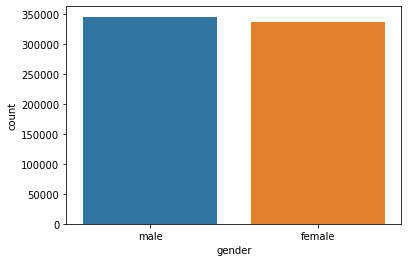

In [7]:
sns.countplot(x="gender", data=df)

**Age:**

In [8]:
df['age'].describe()

count    681284.000000
mean         23.932326
std           7.786009
min          13.000000
25%          17.000000
50%          24.000000
75%          26.000000
max          48.000000
Name: age, dtype: float64

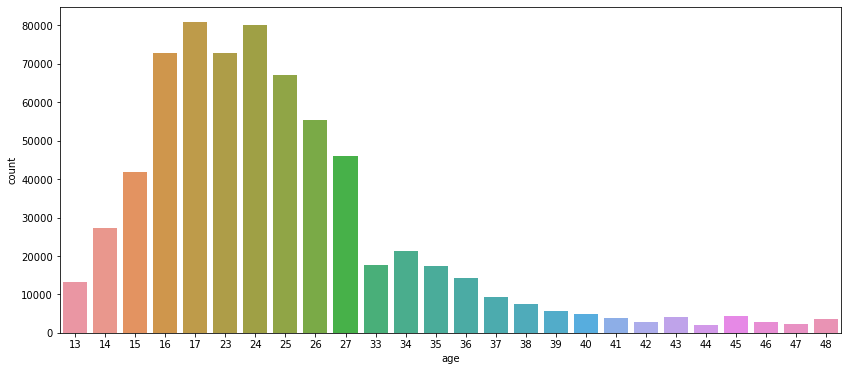

In [9]:
plt.figure(figsize = (14,6))
sns.countplot(x="age", data=df)

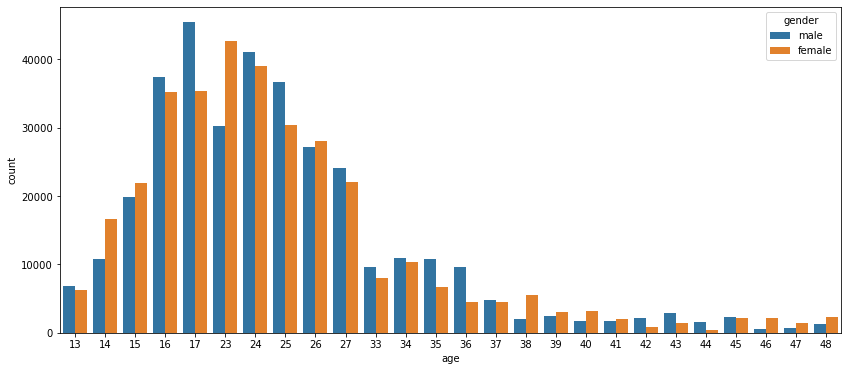

In [10]:
plt.figure(figsize = (14,6))
sns.countplot(x="age", hue="gender", data=df, )

**let's see how long text of blog posts are**

In [11]:
df['number of words'] = df['text'].apply( lambda text: len(text.split()))

In [12]:
df['number of words'].describe()

count    681284.000000
mean        200.786742
std         415.160622
min           0.000000
25%          37.000000
50%         112.000000
75%         255.000000
max      131169.000000
Name: number of words, dtype: float64

In [13]:
empty_text = len(df[df['number of words'] == 0])
print(f'number of empty texts: { empty_text }')

number of empty texts: 3119


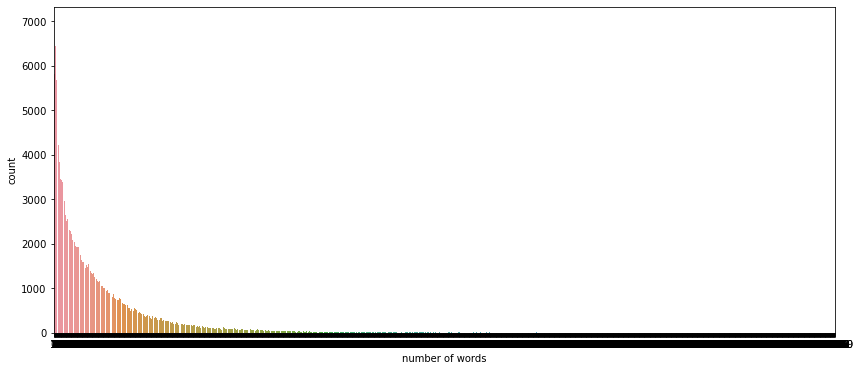

In [15]:
#df['trimmed number of words'] = df['number of words'].apply(lambda x: min(x, 1000))

plt.figure(figsize = (14,6))
sns.countplot(x="number of words", data=df, orient = 'h')

In [16]:
df['gender'] = df['gender'].apply(lambda gender: gender == 'male')

In [17]:
texts, target = df['text'], df['gender']

One of the problems  with neural nets that often it takes a lot of time, to train NN model. So, for simplicity we will use only $ 20\%$ of our data

In [18]:
texts = texts[::5]
target = target[::5]

Split data on train and test

In [20]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.2, random_state=42)

Now we need to prepare our data. To do that, we split out texts to words then transform all words into numbers. 
Also, we need to have fix size of text for RNN models, so we use padding’s to solve this problem. 

In [21]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: tokenizer.tokenize(text.lower())

In [22]:
texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]


In [23]:
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()             
word_tokenizer.fit_on_texts(texts_train)         

X_train = word_tokenizer.texts_to_sequences(texts_train)
X_test =  word_tokenizer.texts_to_sequences(texts_test)

# look at first encoded data point
print(" Encoded data  example: \n")
print('X: ', X_train[0], '\n')

 Encoded data  example: 

X:  [45, 23, 695, 2, 4, 164, 292, 248, 355, 5, 28, 92, 23, 81, 18, 167, 156, 28440, 15, 740, 40, 240, 203, 136, 5962, 10, 1483, 64, 2852, 165, 4679, 1174, 23182, 15, 6532, 2, 1779, 14, 7, 196, 8, 1316, 1, 4, 19, 23, 245, 5, 97, 1407, 3870, 59, 1, 11, 19, 23, 5192, 1, 106, 38, 8697, 10209, 2, 35, 19, 3, 1550, 6235, 18, 850, 100, 7967, 389, 10, 23, 172, 1, 4, 369, 39, 106, 50, 35, 90, 1160, 734, 2, 1770, 119, 28, 59, 364, 1, 75, 1407, 1, 4, 63, 45, 40, 18949, 56, 3, 14173, 432, 567, 231, 5, 36832, 6475, 2, 22, 4, 71, 52, 63, 132, 435, 3, 296, 8, 9828, 3, 2453, 8, 167, 83, 17, 97, 20, 1743, 395, 364, 169, 1, 4, 147, 7, 700, 23673, 364, 5, 91, 2, 42, 59, 10, 3361, 1747, 2, 3416, 878, 18, 183, 3, 132, 62, 10, 502, 1] 



In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQ_LENGTH = 256

X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [26]:
VOCABULARY_SIZE = np.max(X_train) + 1
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  316559


There is always the question whether or not to use pre-trained embeddings. In this work we decided to use pre-trained   fasttext embeddings but allow model to change them. 

In [27]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")
EMBEDDING_SIZE = 300

In [28]:
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# copy vectors from word2vec model to the words present in corpus
not_in_embed = []
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = embeddings[word]
    except KeyError:
        not_in_embed.append(word)
        
print("number of words which don't have embedding = ", len(not_in_embed))

number of words which don't have embedding =  197843


In [29]:
print("some words which don't have embedding: " ,not_in_embed[::10000] )

some words which don't have embedding:  ["i'm", 'mmchronic', 'scheister', 'christospective', 'yoozh', 'rockwell-esque', 'scan-tron', 'avontuurlijke', 'halooooooo', "turret's", 'exahausted', 'sub-profiles', "percy's", 'adultchildrenspeakoutaboutsamesexparents', 'niya-jina', 'thoughtsabout', 'planne', "freder's", 'soon-to-be-closed', 'calve-deep']


yeah,  as you may see there is the problem with сontraction, slangs and so on. But as we decided to tune embeddings that shouldn’t effect so much.    

## CNN

Let's start our experiments with convolutional neural network. 

In [30]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

model_cnn = Sequential()
model_cnn.add(layers.Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQ_LENGTH, weights = [embedding_weights]))
model_cnn.add(layers.Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(1, activation='softmax'))

In [31]:
model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 300)          94967700  
_________________________________________________________________
conv1d (Conv1D)              (None, 252, 250)          375250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 95,375,207
Trainable params: 95,375,207
Non-trainable params: 0
_________________________________________________________________


During training we will store information about our score. It helps us to see problems with overfitting.

In [32]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [33]:
history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=3,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/3
767/767 [==============================] - ETA: 0s - loss: 7.5096 - accuracy: 0.5075
Epoch 00001: val_accuracy improved from -inf to 0.50555, saving model to best_model_cnn.h5
767/767 [==============================] - 1100s 1s/step - loss: 7.5096 - accuracy: 0.5075 - val_loss: 7.5400 - val_accuracy: 0.5055
Epoch 2/3
767/767 [==============================] - ETA: 0s - loss: 7.5096 - accuracy: 0.5075
Epoch 00002: val_accuracy did not improve from 0.50555
767/767 [==============================] - 1067s 1s/step - loss: 7.5096 - accuracy: 0.5075 - val_loss: 7.5400 - val_accuracy: 0.5055
Epoch 3/3
767/767 [==============================] - ETA: 0s - loss: 7.5096 - accuracy: 0.5075
Epoch 00003: val_accuracy did not improve from 0.50555
767/767 [==============================] - 1002s 1s/step - loss: 7.5096 - accuracy: 0.5075 - val_loss: 7.5400 - val_accuracy: 0.5055


Hm, it didn't work at all. Okay, we'll move on.

## LSTM

In [37]:
def create_rnn_binary_clf(rnn_layer, embedding_size = EMBEDDING_SIZE ,embedding_weights = None, train_embedding = True):
    rnn_clf = Sequential()
    
    rnn_clf.add(layers.Embedding(input_dim = VOCABULARY_SIZE, 
                                   output_dim = embedding_size, 
                                   input_length = MAX_SEQ_LENGTH, 
                                   trainable = train_embedding,   # True — update the embeddings  
                                   weights = [embedding_weights] if embedding_weights is not None else None
                                   ))
    rnn_clf.add(rnn_layer)
    rnn_clf.add(layers.Dense(1, activation='sigmoid'))
    rnn_clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return rnn_clf

In [39]:

model_lstm = create_rnn_binary_clf(rnn_layer = layers.LSTM(64),  embedding_weights = embedding_weights)
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 300)          94967700  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 95,061,205
Trainable params: 95,061,205
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [41]:
history_lstm = model_lstm.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
767/767 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.5863
Epoch 00001: val_accuracy improved from -inf to 0.57499, saving model to best_model_lstm.h5
767/767 [==============================] - 989s 1s/step - loss: 0.6699 - accuracy: 0.5863 - val_loss: 0.6706 - val_accuracy: 0.5750
Epoch 2/5
767/767 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.6856
Epoch 00002: val_accuracy improved from 0.57499 to 0.67581, saving model to best_model_lstm.h5
767/767 [==============================] - 1034s 1s/step - loss: 0.5890 - accuracy: 0.6856 - val_loss: 0.6103 - val_accuracy: 0.6758
Epoch 3/5
767/767 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8039
Epoch 00003: val_accuracy did not improve from 0.67581
767/767 [==============================] - 1061s 1s/step - loss: 0.4235 - accuracy: 0.8039 - val_loss: 0.6730 - val_accuracy: 0.6672
Epoch 4/5
767/767 [==============================] - ETA: 0s - loss: 0.2494

In [42]:
def plot_train_process(history_model, title = None):
    plt.figure(figsize = (14,6))
    plt.plot(history_model.history['accuracy'], 
         label='train accuracy')
    plt.plot(history_model.history['val_accuracy'], 
             label='validation accuracy')
    plt.xlabel('epoch number')
    plt.ylabel('accuracy')
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

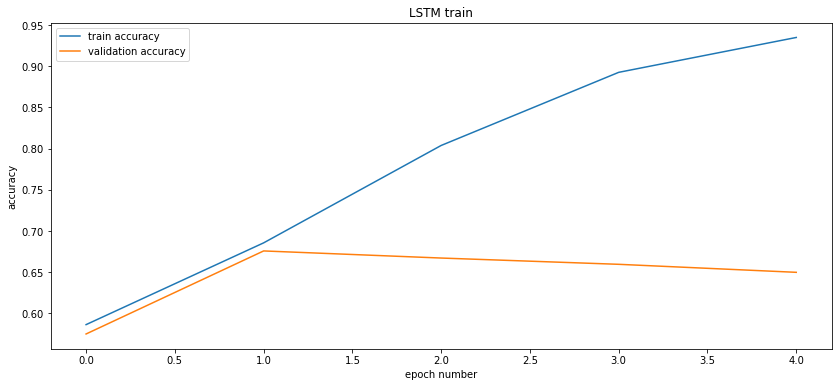

In [43]:
plot_train_process(history_lstm, "LSTM train")

So, we may see that after 2 epochs our model starts to overfitting. That is bad news.

But anyway let's look at test results.

In [44]:
model_lstm.evaluate(X_test, y_test, verbose=1)

852/852 [==============================] - 29s 35ms/step - loss: 1.0055 - accuracy: 0.6446


[1.0055115222930908, 0.6446499228477478]

There are some ways to fix overfitting problem. Firstly, let's add regulations to RNN model. And also reduce  sell number. Why do we actually take 64 cells?

In [45]:
from keras.regularizers import L1L2

In [46]:
model_lstm_reg_save_path = 'best_model_lstm_reg.h5'
checkpoint_callback_lstm_reg = ModelCheckpoint(model_lstm_reg_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [47]:
reg = L1L2(l2 = 0.01)
model_lstm_reg = create_rnn_binary_clf(rnn_layer = layers.LSTM(16, kernel_regularizer = reg), embedding_weights = embedding_weights)
model_lstm_reg.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 300)          94967700  
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 94,988,005
Trainable params: 94,988,005
Non-trainable params: 0
_________________________________________________________________


In [48]:
history_lstm_reg = model_lstm_reg.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm_reg])

Epoch 1/5
767/767 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.6281
Epoch 00001: val_accuracy improved from -inf to 0.64820, saving model to best_model_lstm_reg.h5
767/767 [==============================] - 977s 1s/step - loss: 0.7025 - accuracy: 0.6281 - val_loss: 0.6302 - val_accuracy: 0.6482
Epoch 2/5
767/767 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7199
Epoch 00002: val_accuracy improved from 0.64820 to 0.66434, saving model to best_model_lstm_reg.h5
767/767 [==============================] - 974s 1s/step - loss: 0.5645 - accuracy: 0.7199 - val_loss: 0.6218 - val_accuracy: 0.6643
Epoch 3/5
767/767 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.7873
Epoch 00003: val_accuracy did not improve from 0.66434
767/767 [==============================] - 945s 1s/step - loss: 0.4687 - accuracy: 0.7873 - val_loss: 0.6403 - val_accuracy: 0.6628
Epoch 4/5
767/767 [==============================] - ETA: 0s - loss: 

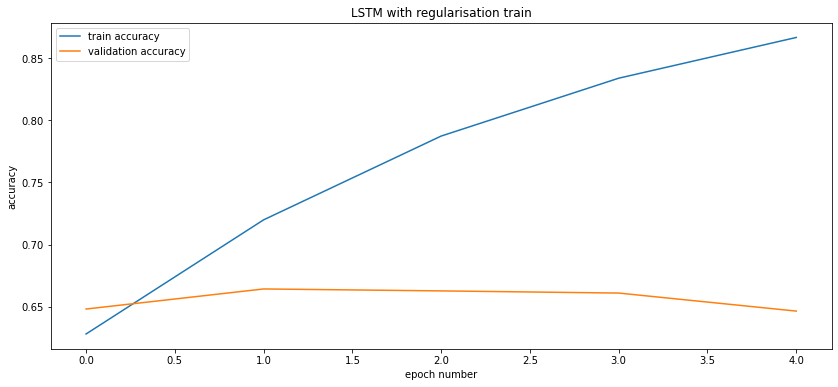

In [49]:
plot_train_process(history_lstm_reg, "LSTM with regularisation train")

In [50]:
model_lstm_reg.evaluate(X_test, y_test, verbose=1)

852/852 [==============================] - 23s 27ms/step - loss: 0.7545 - accuracy: 0.6411


[0.7544564008712769, 0.6410905718803406]

So, these changes didn't help us. Now overfitting is little bit less but still huge 

Another try to fix that problem. We add more regularisation , dropout and  decreased   embedding dimention. 

In [51]:
reg = L1L2(l2 = 0.1)
model_lstm_reg2 = create_rnn_binary_clf(rnn_layer = layers.LSTM(16, kernel_regularizer = reg, dropout = 0.1), embedding_size = 100)
model_lstm_reg2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 256, 100)          31655900  
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 31,663,405
Trainable params: 31,663,405
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_lstm_reg2_save_path = 'best_model_lstm_reg2.h5'
checkpoint_callback_lstm_reg2 = ModelCheckpoint(model_lstm_reg2_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [53]:
history_lstm_reg2 = model_lstm_reg2.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm_reg2])

Epoch 1/5
767/767 [==============================] - ETA: 0s - loss: 1.2124 - accuracy: 0.6186
Epoch 00001: val_accuracy improved from -inf to 0.64077, saving model to best_model_lstm_reg2.h5
767/767 [==============================] - 380s 496ms/step - loss: 1.2124 - accuracy: 0.6186 - val_loss: 0.6352 - val_accuracy: 0.6408
Epoch 2/5
767/767 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7121
Epoch 00002: val_accuracy improved from 0.64077 to 0.67728, saving model to best_model_lstm_reg2.h5
767/767 [==============================] - 382s 498ms/step - loss: 0.5718 - accuracy: 0.7121 - val_loss: 0.6142 - val_accuracy: 0.6773
Epoch 3/5
767/767 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.7458
Epoch 00003: val_accuracy did not improve from 0.67728
767/767 [==============================] - 388s 506ms/step - loss: 0.5400 - accuracy: 0.7458 - val_loss: 0.6540 - val_accuracy: 0.6625
Epoch 4/5
767/767 [==============================] - ETA: 

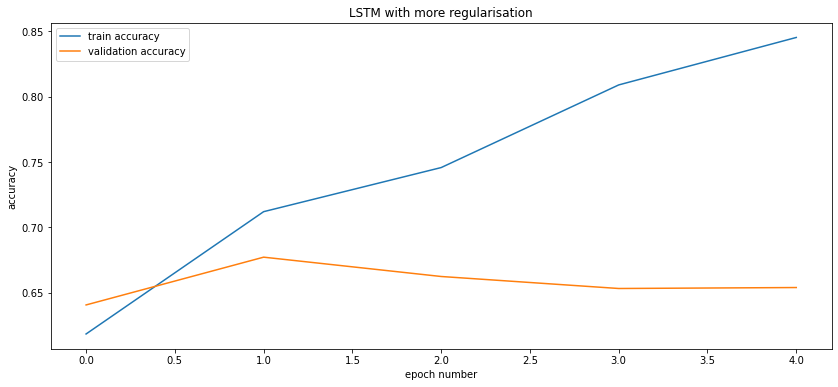

In [54]:
plot_train_process(history_lstm_reg2, "LSTM with more regularisation")

In [55]:
model_lstm_reg2.evaluate(X_test, y_test, verbose=1)

852/852 [==============================] - 13s 15ms/step - loss: 0.7312 - accuracy: 0.6502


[0.7311899065971375, 0.6501541137695312]

This approach  give better results but we still have overfitting.

Who knows, may be GRU  can help us. At least that model has less parameters.

In [59]:
reg = L1L2(l2 = 0.1)
model_gru = create_rnn_binary_clf(rnn_layer = layers.GRU(16, kernel_regularizer = reg), embedding_size = 100)
model_gru.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 256, 100)          31655900  
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                5664      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 31,661,581
Trainable params: 31,661,581
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [61]:
history_gru = model_gru.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
767/767 [==============================] - ETA: 0s - loss: 1.1707 - accuracy: 0.6045
Epoch 00001: val_accuracy improved from -inf to 0.65746, saving model to best_model_gru.h5
767/767 [==============================] - 391s 510ms/step - loss: 1.1707 - accuracy: 0.6045 - val_loss: 0.6238 - val_accuracy: 0.6575
Epoch 2/5
767/767 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.7026
Epoch 00002: val_accuracy did not improve from 0.65746
767/767 [==============================] - 389s 507ms/step - loss: 0.5777 - accuracy: 0.7026 - val_loss: 0.6724 - val_accuracy: 0.6295
Epoch 3/5
767/767 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.7698
Epoch 00003: val_accuracy did not improve from 0.65746
767/767 [==============================] - 392s 510ms/step - loss: 0.4870 - accuracy: 0.7698 - val_loss: 0.6705 - val_accuracy: 0.6451
Epoch 4/5
767/767 [==============================] - ETA: 0s - loss: 0.4024 - accuracy: 0.8207
Epoch 00004: v

In [62]:
model_gru.evaluate(X_test, y_test, verbose=1)

852/852 [==============================] - 14s 16ms/step - loss: 0.7481 - accuracy: 0.6395


[0.7481415271759033, 0.6395493745803833]

Unfortunately , not in this time....

At the end let's use bidirectional LSTM

In [68]:
reg = L1L2(l2 = 0.1)
model_bidirectional = create_rnn_binary_clf(layers.Bidirectional(layers.LSTM(16,kernel_regularizer = reg, dropout = 0.1 )), embedding_size = 100)
model_bidirectional.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 256, 100)          31655900  
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                14976     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 31,670,909
Trainable params: 31,670,909
Non-trainable params: 0
_________________________________________________________________


In [69]:
model_bidirectional_save_path = 'best_model_bidirectional.h5'
checkpoint_callback_bidirectional = ModelCheckpoint(model_bidirectional_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [70]:
history_bidirectional = model_bidirectional.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_bidirectional])

Epoch 1/5
767/767 [==============================] - ETA: 0s - loss: 1.8203 - accuracy: 0.6028
Epoch 00001: val_accuracy improved from -inf to 0.64223, saving model to best_model_bidirectional.h5
767/767 [==============================] - 412s 537ms/step - loss: 1.8203 - accuracy: 0.6028 - val_loss: 0.6394 - val_accuracy: 0.6422
Epoch 2/5
767/767 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6766
Epoch 00002: val_accuracy improved from 0.64223 to 0.65269, saving model to best_model_bidirectional.h5
767/767 [==============================] - 417s 544ms/step - loss: 0.6141 - accuracy: 0.6766 - val_loss: 0.6293 - val_accuracy: 0.6527
Epoch 3/5
767/767 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.7383
Epoch 00003: val_accuracy improved from 0.65269 to 0.66104, saving model to best_model_bidirectional.h5
767/767 [==============================] - 452s 589ms/step - loss: 0.5407 - accuracy: 0.7383 - val_loss: 0.6240 - val_accuracy: 0.6610
E

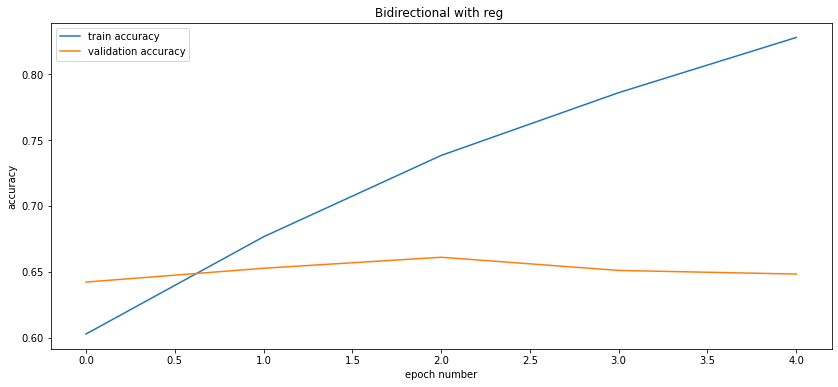

In [71]:
plot_train_process(history_bidirectional, "Bidirectional with reg ")

In [72]:
model_bidirectional.evaluate(X_test, y_test, verbose=1)

852/852 [==============================] - 14s 17ms/step - loss: 0.6844 - accuracy: 0.6452


[0.6843703389167786, 0.6451636552810669]

Nothing changed. 

**Conclusion**

We tried to beat results, received in task one. Unfortunately , we did not achieve better results. There are some lessons that we could learn out of it. 

1) neural nets may overfitting.
2) There are some ways to fix that but there is no guarantee  that it would help.
3) It was common knowledge, that NN requires a lot of data. So, increasing data is also a good way to decrease overfitting. 